In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import functools
import alive_progress
from alive_progress import alive_bar

In [2]:
df1 = pd.DataFrame(yf.download("RUB=X", start="2004-02-13", end="2021-12-31")['Close']) 
df1.columns = ['USD Close']
df2 = pd.DataFrame(yf.download("EURRUB=X", start="2004-02-13", end="2021-12-31")['Close'])
df2.columns = ['EURRUB Close']
df3 = pd.DataFrame(yf.download("GBPRUB=X", start="2004-02-13", end="2021-12-31")['Close'])
df3.columns = ['GBPRUB Close']
df4 = pd.DataFrame(yf.download("INR=X", start="2004-02-13", end="2021-12-31")['Close'])
df4.columns = ['INR Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
rates1 = pd.ExcelFile("Валюты.xlsx").parse("Лист1")
rates1.index = rates1['Date']
rates1 = rates1.drop('Date', axis=1)
rates2 = pd.ExcelFile("Валюты.xlsx").parse("Лист2")
rates2.index = rates2['Date']
rates2 = rates2.drop('Date', axis=1)
rates3 = pd.ExcelFile("Валюты.xlsx").parse("Лист3")
rates3.index = rates3['Date']
rates3 = ((1+rates3.drop('Date', axis=1)/100)**(1/252)-1)
rates4 = pd.ExcelFile("mos.xlsx").parse("Sheet1")
rates4.index = rates4['Date']
rates4 = ((1+rates4.drop('Date', axis=1)/100)**(1/252)-1)
rates4


df_rates = rates1.merge(rates2, on = 'Date')
data1 = ((1+df_rates[['Value USD', 'Value GBP', 'Value EUR']]/100)**(1/252)-1)
rates_final = data1.merge(rates3, on = 'Date')
rates_final.index = pd.to_datetime(rates_final.index)
rates_final = rates_final.merge(rates4, on = 'Date')



FileNotFoundError: [Errno 2] No such file or directory: 'mos.xlsx'

In [4]:
df = df1.merge(df2, on = 'Date').merge(df3, on = 'Date').merge(df4, on = 'Date')   

In [5]:
df = df.merge(rates_final, on = 'Date')

In [6]:
train, test = df[:'2017-12-29'], df['2018-01-01':]
train.columns

Index(['USD Close', 'EURRUB Close', 'GBPRUB Close', 'INR Close', 'Value USD',
       'Value GBP', 'Value EUR', 'Value INR', 'RUB value'],
      dtype='object')

In [11]:
def get_sharp_momentum(b, m):
    cum_ret_lst = [[],[],[],[]]
    sigma = []
    log_ret = [] 
    for z in range(len(['USD Close', 'EURRUB Close', 'GBPRUB Close', 'INR Close'])):
        element = ['USD Close', 'EURRUB Close', 'GBPRUB Close', 'INR Close'][z]
        column = ['Value USD', 'Value EUR', 'Value GBP', 'Value INR'][z]
        ret = []
        cum_ret_lst[z].append(0)
        for i in range(m, pd.DataFrame(train[element]).shape[0]):
            ok = 1
            ok2 = 1
            cum_ret = 0
            for j in range(m):
                cum_ret += np.log(train[element][i-j-1]) - np.log(train[element][i-j-2])
                if cum_ret < b:
                    ok = 0
                if cum_ret > -b:
                    ok2 = 0
            
            # + r*np.log(train[element][i-1]) foreign interest
            # print(ok, ok2, ret_loc)
            if ok == 1 and train[column][i-1] >= 0:
                ret_loc = np.log(train[element][i]) - np.log(train[element][i-1]) + np.log(1+train[column][i-1])-np.log(1+train['RUB value'][i-1])
                ret.append(ret_loc)
            elif ok == 1 and train[column][i-1] < 0:
                ret_loc = np.log(train[element][i]) - np.log(train[element][i-1])-np.log(1+train['RUB value'][i-1])
                ret.append(ret_loc)
            elif ok2 == 1 and train[column][i-1] >= 0:
                ret_loc = np.log(train[element][i]) - np.log(train[element][i-1]) + np.log(1+train[column][i-1])-np.log(1+train['RUB value'][i-1])
                ret.append(-ret_loc)
            elif ok2 == 1 and train[column][i-1] < 0:
                ret_loc = np.log(train[element][i]) - np.log(train[element][i-1]) -np.log(1+train['RUB value'][i-1])
                ret.append(-ret_loc)
            else:
                ret.append(0)

            cum_ret_lst[z].append(cum_ret_lst[z][-1] + ret[-1]) # При добавлении доходности весь прошлый ретерн должен домножаться на рублевую ставку

        # plt.plot(cum_ret_lst)
        # annual volatility of the strategy
        log_ret.append(ret)
    return(cum_ret_lst, log_ret)

In [ ]:
print(answers[0][sharp_list.index(np.max(sharp_list))])
print(answers[1][sharp_list.index(np.max(sharp_list))])
# m=1; b = 0.016

In [12]:
w1 = 1
w2 = -1
w3 = -1
def get_profit(b, m):
    cum_ret_lst = [[],[],[],[]]
    trade = [[],[],[],[]]
    sigma = []
    log_ret = [] 
    for z in range(len(['USD Close', 'EURRUB Close', 'GBPRUB Close', 'INR Close'])):
        element = ['USD Close', 'EURRUB Close', 'GBPRUB Close', 'INR Close'][z]
        column = ['Value USD', 'Value EUR', 'Value GBP', 'Value INR'][z]
        ret = []
        cum_ret_lst[z].append(0)
        for i in range(m, pd.DataFrame(test[element]).shape[0]):
            ok = 1
            ok2 = 1
            cum_ret = 0
            for j in range(m):
                cum_ret += np.log(test[element][i-j-1]) - np.log(test[element][i-j-2])
                if cum_ret < b:
                    ok = 0
                if cum_ret > -b:
                    ok2 = 0
            
            # + r*np.log(train[element][i-1]) foreign interest
            # print(ok, ok2, ret_loc)
            if ok == 1 and test[column][i-1] >= 0:
                ret_loc = np.log(test[element][i]) - np.log(test[element][i-1]) + np.log(1+test[column][i-1])-np.log(1+test['RUB value'][i-1])
                ret.append(0.9975*ret_loc)
            elif ok == 1 and test[column][i-1] < 0:
                ret_loc = np.log(test[element][i]) - np.log(test[element][i-1])-np.log(1+test['RUB value'][i-1])
                ret.append(0.9975*ret_loc)
            elif ok2 == 1 and test[column][i-1] >= 0:
                ret_loc = np.log(test[element][i]) - np.log(test[element][i-1]) + np.log(1+test[column][i-1])-np.log(1+test['RUB value'][i-1])
                ret.append(-ret_loc*0.9975)
            elif ok2 == 1 and test[column][i-1] < 0:
                ret_loc = np.log(test[element][i]) - np.log(test[element][i-1]) -np.log(1+test['RUB value'][i-1])
                ret.append(-ret_loc*0.99975)
            else:
                ret.append(np.log(1+test['RUB value'][i]+np.random.uniform(-0.0005,0.0005)))

            cum_ret_lst[z].append(cum_ret_lst[z][-1] + ret[-1]) # При добавлении доходности весь прошлый ретерн должен домножаться на рублевую ставку
            trade[z].append(1*ok+1*ok2)
        # plt.plot(cum_ret_lst)
        # annual volatility of the strategy
        log_ret.append(ret)
    return(cum_ret_lst, log_ret, trade)

In [13]:
usd = np.array(get_profit(0.016, 1)[0][0])
eur = np.array(get_profit(0.016, 1)[0][1])
pound = np.array(get_profit(0.016, 1)[0][2])
rup = np.array(get_profit(0.016, 1)[0][3])

In [14]:
weighted_cum_ret = w1*usd+w2*eur+w3*pound + (1-w1-w2-w3)*rup

In [15]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'cumulative log return')

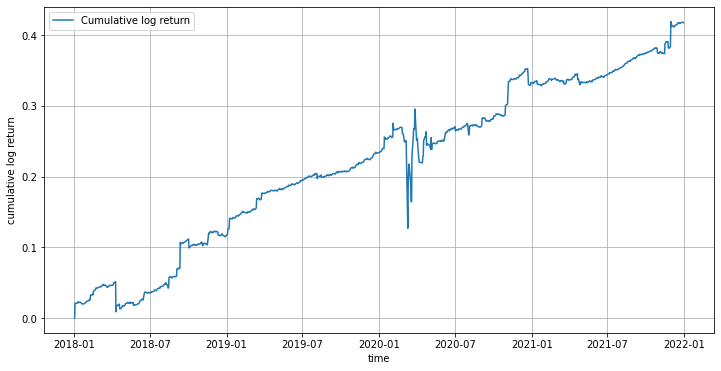

In [16]:
plt.figure(figsize=(12, 6))
display(plt.plot(df['2018-01-01':].index,weighted_cum_ret, label = 'Cumulative log return'))
plt.grid()
plt.legend()
plt.xlabel('time')
plt.ylabel('cumulative log return')

In [33]:
df5 = pd.read_csv('UUP.csv')
df5.index = pd.to_datetime(df5['Date'])
df5 = df5.drop('Date', axis = 1)
df5_new = df5.merge(df1, on = 'Date')
df5_new['Value rub'] = df5_new['Close']*df5_new['USD Close']
df5_new

data = np.array(df5_new['Value rub'])
log_ret = []
for i in range(len(data)):
    if i != len(data)-1:
        log_ret.append(np.log(data[i+1])-np.log(data[i]))
        
log_ret
cum_log_ret = [0]
for element in log_ret:
    cum_log_ret.append(cum_log_ret[-1]+element)
    
cum_log_ret

[0,
 0.002798309979064051,
 -0.0076674706497721345,
 -0.009409348004063567,
 -0.004535799647129579,
 -0.0006741352218355701,
 -0.00721924873327584,
 -0.008556678806837859,
 -0.028166149335507207,
 -0.037089231587237315,
 -0.03213748345176004,
 -0.026009829745581747,
 -0.030868081178533124,
 -0.03250912737790568,
 -0.03739492693136359,
 -0.049233101585548056,
 -0.05085295628510522,
 -0.05840609717990031,
 -0.05000761153451361,
 -0.05043353097409842,
 -0.0510445343322683,
 -0.05869218485816763,
 -0.05686375654515885,
 -0.044189718393253585,
 -0.02670495536053874,
 -0.026748383097516815,
 -0.009958712108326218,
 -0.0009456895770147966,
 -0.0037535064343936497,
 -0.019051134820904814,
 -0.029080724155175375,
 -0.049554403029928196,
 -0.04810109520088801,
 -0.04183371460012886,
 -0.03559389612459185,
 -0.035479206792981444,
 -0.037738889322946,
 -0.04154142413144779,
 -0.047565394579124565,
 -0.03404889201429384,
 -0.035629556513494975,
 -0.03163051667458827,
 -0.02870807704506184,
 -0.0407

In [34]:
np.std(np.array(log_ret))*252**0.5

0.1547507074043675

Text(0, 0.5, 'cumulative log return')

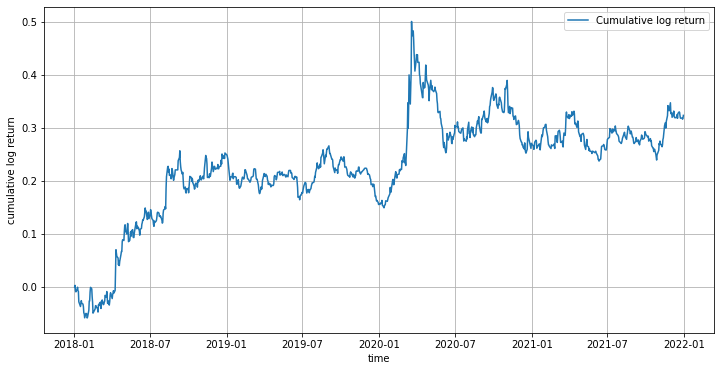

In [18]:
plt.figure(figsize=(12, 6))
display(plt.plot(df5_new.index, cum_log_ret, label = 'Cumulative log return'))
plt.grid()
plt.legend()
plt.xlabel('time')
plt.ylabel('cumulative log return')

In [35]:
df6 = pd.read_csv('FXB.csv')
df6.index = pd.to_datetime(df6['Date'])
df6 = df6.drop('Date', axis = 1)
df6_new = df6.merge(df1, on = 'Date')
df6_new['Value rub'] = df6_new['Close']*df6_new['USD Close']
df6_new

data2 = np.array(df6_new['Value rub'])
log_ret2 = []
for i in range(len(data2)):
    if i != len(data2)-1:
        log_ret2.append(np.log(data2[i+1])-np.log(data2[i]))
        
log_ret2
cum_log_ret2 = [0]
for element in log_ret2:
    cum_log_ret2.append(cum_log_ret2[-1]+element)
    
cum_log_ret2

[0,
 -0.007104308960618866,
 -0.011420683694227662,
 -0.012935100807455413,
 -0.01271787961490567,
 -0.012905523072552327,
 -0.01893805019099304,
 -0.014360532774134072,
 -0.008915323371869732,
 -0.008004296748511663,
 -0.0013507333612157169,
 0.008569209793268584,
 0.00023830468661678594,
 0.010780029958823434,
 0.009105039138983528,
 0.022348793012806567,
 0.013995150521276756,
 0.009608121502346023,
 0.010106411171557639,
 0.016357391725350112,
 0.020957553988534272,
 0.023689566107547577,
 0.009046289416552611,
 0.00592715360396312,
 0.02031622743289141,
 0.007587162213219756,
 0.025710621199001693,
 0.028679779924010163,
 0.029711151981612005,
 0.023812600126492,
 0.030062074128691663,
 0.020421007415308168,
 0.009123209504517504,
 0.0072803699267609545,
 0.004451816334468006,
 0.00996659999405658,
 0.006904519310554136,
 0.004232003255042471,
 -0.011781132909669978,
 -0.01193335549881347,
 -0.009533341415835395,
 0.0001289503811943149,
 0.00699850385755596,
 0.0002887280931389568

In [36]:
np.std(np.array(log_ret2))*252**0.5

0.15123315882497176

Text(0, 0.5, 'cumulative log return')

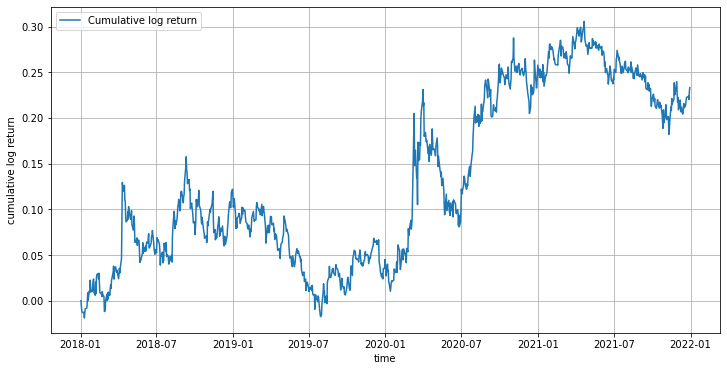

In [20]:
plt.figure(figsize=(12, 6))
display(plt.plot(df6_new.index, cum_log_ret2, label = 'Cumulative log return'))
plt.grid()
plt.legend()
plt.xlabel('time')
plt.ylabel('cumulative log return')

Text(0, 0.5, 'cumulative log return')

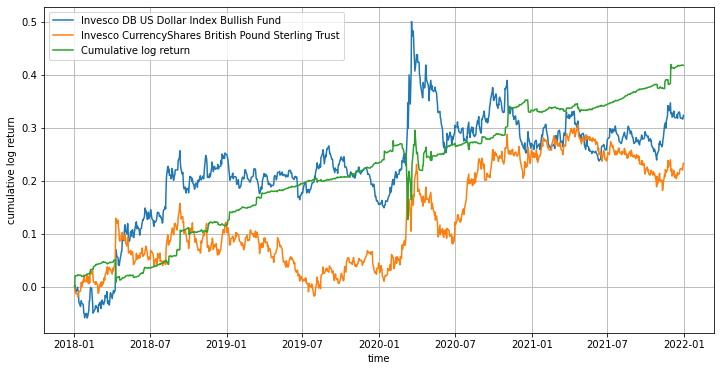

In [21]:
plt.figure(figsize=(12, 6))
display(plt.plot(df5_new.index, cum_log_ret, label = 'Invesco DB US Dollar Index Bullish Fund'))
display(plt.plot(df6_new.index, cum_log_ret2, label = 'Invesco CurrencyShares British Pound Sterling Trust'))
display(plt.plot(df['2018-01-01':].index,weighted_cum_ret, label = 'Cumulative log return'))
plt.grid()
plt.legend()
plt.xlabel('time')
plt.ylabel('cumulative log return')

In [22]:
usd_hold = get_profit(0.016, 1)[2][0].count(0)/len(get_profit(0.016, 1)[2][0])
usd_trade = 1-get_profit(0.016, 1)[2][0].count(0)/len(get_profit(0.016, 1)[2][0])
eur_hold = get_profit(0.016, 1)[2][1].count(0)/len(get_profit(0.016, 1)[2][1])
eur_trade = 1-get_profit(0.016, 1)[2][1].count(0)/len(get_profit(0.016, 1)[2][1])
pound_hold = get_profit(0.016, 1)[2][2].count(0)/len(get_profit(0.016, 1)[2][2])
pound_trade = 1-get_profit(0.016, 1)[2][2].count(0)/len(get_profit(0.016, 1)[2][2])
rup_hold = get_profit(0.016, 1)[2][3].count(0)/len(get_profit(0.016, 1)[2][3])
rup_trade = 1-get_profit(0.016, 1)[2][3].count(0)/len(get_profit(0.016, 1)[2][3])

In [23]:
rup_trade

0.008910891089108919

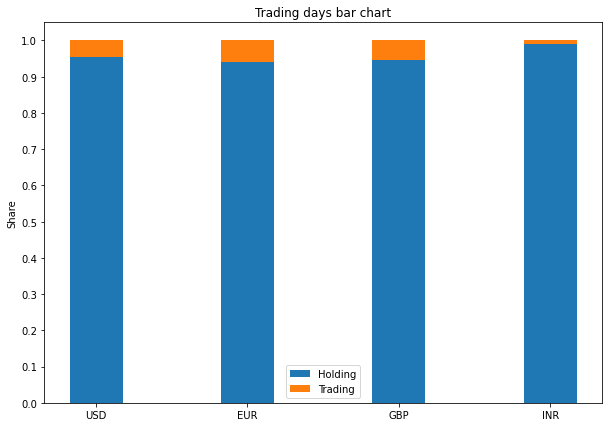

In [24]:
ind = np.arange(4)
hold = [usd_hold, eur_hold, pound_hold, rup_hold]
trade = [usd_trade, eur_trade, pound_trade, rup_trade]
fig = plt.subplots(figsize =(10, 7))
p1 = plt.bar(ind, hold, 0.35)
p2 = plt.bar(ind, trade, 0.35,
             bottom = hold)
 
plt.ylabel('Share')
plt.title('Trading days bar chart')
plt.xticks(ind, ('USD', 'EUR', 'GBP', 'INR'))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend((p1[0], p2[0]), ('Holding', 'Trading'))
 
plt.show()

Text(0, 0.5, 'Log return')

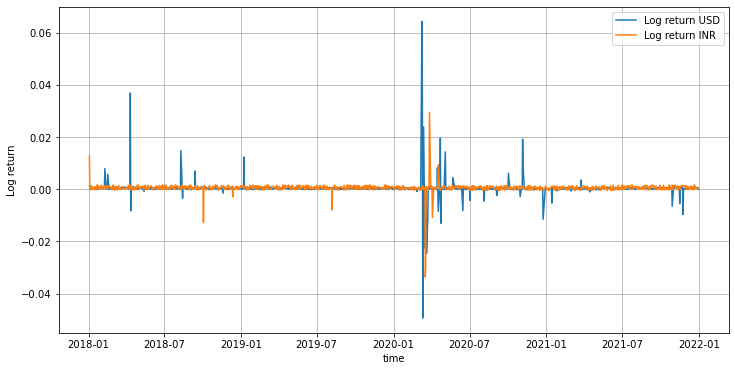

In [25]:
cum_ret = get_profit(0.016, 1)[1]
plt.figure(figsize=(12, 6))
display(plt.plot(df['2018-01-03':].index,cum_ret[0], label = 'Log return USD'))
display(plt.plot(df['2018-01-03':].index,2*np.array(cum_ret[3]), label = 'Log return INR'))
plt.grid()
plt.legend()
plt.xlabel('time')
plt.ylabel('Log return')

Text(0, 0.5, 'Log return')

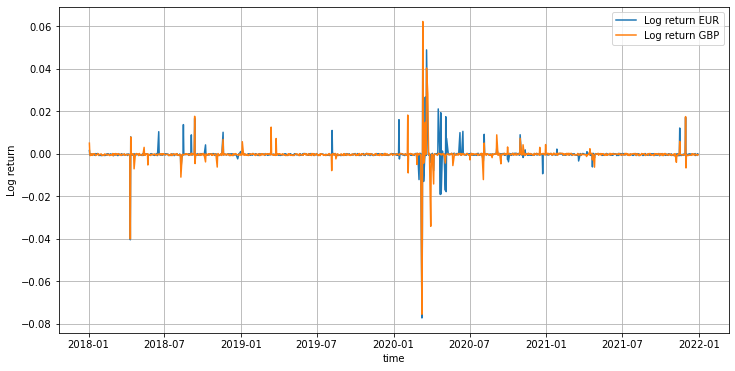

In [26]:
cum_ret = get_profit(0.016, 1)[1]
plt.figure(figsize=(12, 6))
display(plt.plot(df['2018-01-03':].index,(-1)*np.array(cum_ret[1]), label = 'Log return EUR'))
display(plt.plot(df['2018-01-03':].index,(-1)*np.array(cum_ret[2]), label = 'Log return GBP'))
plt.grid()
plt.legend()
plt.xlabel('time')
plt.ylabel('Log return')

Text(0, 0.5, 'Log return')

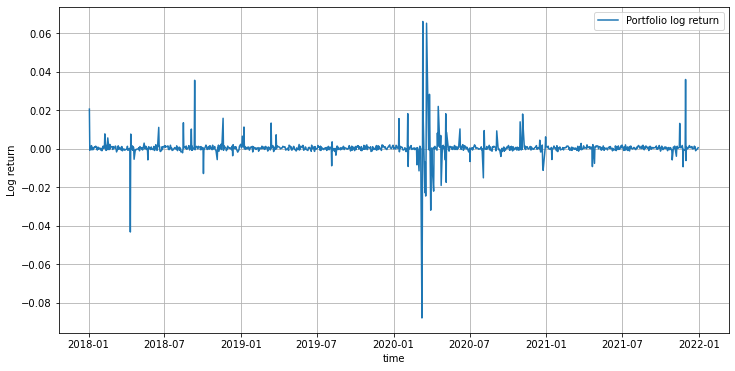

In [27]:
cum_ret = get_profit(0.016, 1)[1]
plt.figure(figsize=(12, 6))
display(plt.plot(df['2018-01-03':].index,np.array(cum_ret[0])-np.array(cum_ret[1])-np.array(cum_ret[2])+2*np.array(cum_ret[3]), label = 'Portfolio log return'))
plt.grid()
plt.legend()
plt.xlabel('time')
plt.ylabel('Log return')

In [30]:
w1= 1
w2 = -1
w3 = -1
w4 = 2
weights = np.array([w1, w2, w3, 1-w1-w2-w3])
log_returns = np.array(get_sharp_momentum(0.016,1)[0])

mean_usd = np.mean(log_returns[-1])
mean_eur = np.mean(log_returns[-1])
mean_pound = np.mean(log_returns[-1])
mean_rup = np.mean(log_returns[-1])
mean = w1*mean_usd + w2*mean_eur +  w3*mean_pound + (1-w1-w2-w3) * mean_rup
sd = np.sqrt(np.dot(weights.T,np.dot(np.cov(log_returns)*252,weights)))
sharp = mean/sd
sharp

-0.0062720150085963655

In [31]:
((1+weighted_cum_ret[-1])**0.25-1-0.07458)/(np.std(sd_new)*252**0.5)

0.1798332803784117

In [32]:
sd_new = np.array(cum_ret[0])-np.array(cum_ret[1])-np.array(cum_ret[2])+2*np.array(cum_ret[3])
np.std(sd_new)*252**0.5

0.09225057443075013